<a href="https://colab.research.google.com/github/davidfague/Stylized-ReducedOrder-L5-Model/blob/main/Soma_Axial_Currents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as ss
from mpl_toolkits import mplot3d
import pdb #python debugger

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Stylized-ReducedOrder-L5-Model/

Mounted at /content/drive
/content/drive/MyDrive/Stylized-ReducedOrder-L5-Model


In [3]:
output_folder = 'Detailedoutput_control'
v = h5py.File('./{}/Detailedv_report.h5'.format(output_folder),'r') #read segment voltage traces
segs = pd.read_csv('Detailedoutput_control/DetailedSegments.csv') # read segment values

In [4]:
segs.head() # visualize columns

,segmentID,BMTK ID,Seg_L,Seg_diam,X,Type,Sec ID,Distance,Section_L,Section_diam,Section_nseg,Section_Ra,Coord X,Coord Y,Coord Z,ParentSegID,Elec_distance
0,0,0,4.633872,9.290377,0.1,soma,0,2.316936,23.169362,17.526643,5,100.0,-9.249733,-0.577674,0.0,NaN,0.998333
1,1,0,4.633872,15.657015,0.3,soma,0,6.950809,23.169362,17.526643,5,100.0,-4.624868,-0.288877,0.0,0.0,0.999377
2,2,0,4.633872,17.526643,0.5,soma,0,11.584681,23.169362,17.526643,5,100.0,-0.000010,0.000021,0.0,1.0,1.000000
3,3,0,4.633872,15.446328,0.7,soma,0,16.218553,23.169362,17.526643,5,100.0,4.624854,0.288824,0.0,2.0,0.999389
4,4,0,4.633872,9.437299,0.9,soma,0,20.852426,23.169362,17.526643,5,100.0,9.249712,0.577722,0.0,3.0,0.998310


In [5]:
#Get Columns
segIDs=segs['segmentID']
# segs = segs.set_index(['Type','Sec ID']).join(segs_degrees.set_index(['Type','Sec ID'])).reset_index() #not sure what this does
segs['Sec ID'] = segs['Sec ID'].astype(int)
segs['X'] = segs['X'].astype(float)
segs['Elec_distanceQ'] = 'None'
AllSegXCoord=segs['Coord X']
AllSegYCoord=segs['Coord Y']
AllSegZCoord=segs['Coord Z']
AllSegSec_ID=segs['Sec ID']
AllSegSec_name=segs['Type']
segLs=segs["Seg_L"]
segxs=segs["X"]
segdists=segs["Distance"]
SegSecL=segs["Section_L"]
segdiams=segs["Seg_diam"]
SegSecnseg=segs["Section_nseg"]
secRas=segs["Section_Ra"]
psegIDs=segs["ParentSegID"]
secids=segs["Sec ID"]
bmtkid=segs["BMTK ID"]
sectypes=segs["Type"]

#get simulation time
seg_v=v['report']['biophysical']['data'][:,0] # get segment 0 voltage trace
print(len(seg_v)) #should be equivalnt to (tstop=1000ms)/(dt=0.1ms)=10000
tstop=1000 #simulation stop
dt=0.1 #timestep
t=np.arange(0,tstop,dt) #time array
print(len(t))
if len(t)!=len(seg_v):
  print('Update Time array')

psegids=[]
for i in range(len(psegIDs)):
  if np.isnan(psegIDs[i]) == False:
    psegids.append(int(psegIDs[i]))
  else:
    psegids.append(psegIDs[i])

10000
10000


In [7]:
probes=[]
class probe():
  def __init__(self,seg,sectionindex,sectionname,color,XCoord,YCoord,ZCoord,secRa,segdiam,segx,segdist,sectionL,sectionNseg,segL,seg_v,parentseg,sectype):
    self.seg=seg
    self.sectionindex=sectionindex
    self.sectionname=sectionname
    self.color=color
    self.XCoord=XCoord
    self.YCoord=YCoord
    self.ZCoord=ZCoord
    self.secRa=secRa
    self.segdiam=segdiam
    self.x=segx
    self.segdist=segdist
    self.secL=sectionL
    self.secnseg=sectionNseg
    self.segL=segL
    self.seg_v=seg_v
    self.name='sec:'+str(self.sectionname)+str(self.sectionindex)+' seg:'+str(self.seg)
    self.adjprobes=[]
    self.parentprobe=[]
    self.childprobes=[]
    self.axialcurrents=[]
    self.parentaxialcurrent=[]
    self.childrenaxialcurrents=[]
    self.halfsegRa=.01*self.secRa*(self.secL/2/self.secnseg)/(np.pi*(self.segdiam/2)**2)
    self.parentseg=parentseg
    self.sectype=sectype

    # try:
    #   self.axial_current=[Record_Axial_Current(section,single_seg=True)]
    # except:
    #   print(section)
for i in range(len(segIDs)):
  newprobe=probe(seg=i,sectionindex=AllSegSec_ID[i],sectionname=str(AllSegSec_name[i]),color='r',XCoord=AllSegXCoord[i],YCoord=AllSegYCoord[i],ZCoord=AllSegZCoord[i],
                secRa=secRas[i],segdiam=segdiams[i],segx=segxs[i],segdist=segdists[i],sectionL=SegSecL[i],sectionNseg=SegSecnseg[i],segL=segLs[i],
                seg_v=v['report']['biophysical']['data'][:,i],parentseg=psegids[i],sectype=sectypes[i])
  probes.append(newprobe)

In [8]:
#getting adjacent segments using parent segment IDs
#getting children segments
for i in range(len(psegids)): #iterate through segment index
  if np.isnan(psegids[i]) == False:
    for seg in segIDs: #check segIDs
      if psegids[i]==seg: #find parent seg from parent seg id
        probes[seg].adjprobes.append(probes[i]) #add child probe to probe's adjprobe list
        probes[seg].childprobes.append(probes[i]) #add child probe to probe's childprobe list
#getting parent segment
for i in range(len(segIDs)):
  if np.isnan(psegids[i]) == False:
    probes[i].adjprobes.append(probes[int(psegids[i])]) #add parent seg probe to adj probes
    probes[i].parentprobe.append(probes[int(psegids[i])]) #add parent seg probe to parent probes

In [9]:
#compute axial currents between all segments
for probe in probes:
  for adjprobe in probe.adjprobes:
    axc=(probe.seg_v-adjprobe.seg_v)/(probe.halfsegRa+adjprobe.halfsegRa) #compute axial current using (v_in-v_out)/(halfsegRa+halfsegRa)
    probe.axialcurrents.append(axc)
    if [adjprobe] == probe.parentprobe:
      probe.parentaxialcurrent.append(axc)
    elif adjprobe in probe.childprobes:
      probe.childrenaxialcurrents.append(axc)

In [11]:
#Find soma segments and adjacent segments
#Usefull subsetting method
# print(segs[(segs.Type=='soma')]) #how to separate by type
somasegIDs = segs[(segs.Type=='soma')]['segmentID'] #how to pull a column after separating by type
print(somasegIDs)
somaprobes=[]
for seg in somasegIDs:
  somaprobes.append(probes[seg])

adjsomaprobes=[]
for probe in somaprobes:
  for adjprobe in probe.adjprobes:
    if adjprobe.sectype != "soma": #need to make sure this works
      adjsomaprobes.append(adjprobe) # get probes adjacent to soma

somaaxialcurrents=[] #list of axial currents going into the soma if needed
for probe in adjsomaprobes:
    somaaxialcurrents.append(probe.parentaxialcurrent) # get axial current from outward segment to soma segment

0    0
1    1
2    2
3    3
4    4
Name: segmentID, dtype: int64


Plot segments adjacent to soma

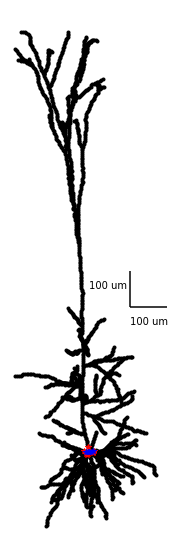

In [19]:
plt.figure(figsize=(3,10))
ax = plt.plot(AllSegXCoord, AllSegYCoord,'.',color='k',markersize=6)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
plt.box(False)

for probe in adjsomaprobes:
  plt.plot(AllSegXCoord[probe.seg],
         AllSegYCoord[probe.seg],
         '*',color=probe.color)

for probe in somaprobes:
  plt.plot(AllSegXCoord[probe.seg],
         AllSegYCoord[probe.seg],
         '*',color='blue')

In [24]:
def plot_parent_axial_current(probe):
  title=probe.name+' Axial Current to Soma'
  plt.figure(figsize=(12.8,4.8))
  plt.plot(t,probe.parentaxialcurrent[0],label=probe.name,color=probe.color)
  plt.ylabel('nA')
  plt.legend()
  plt.title(title)
  plt.xlabel('time (ms)')
  plt.show()

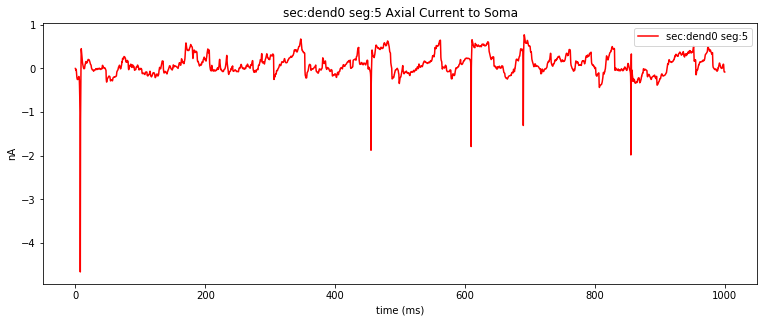

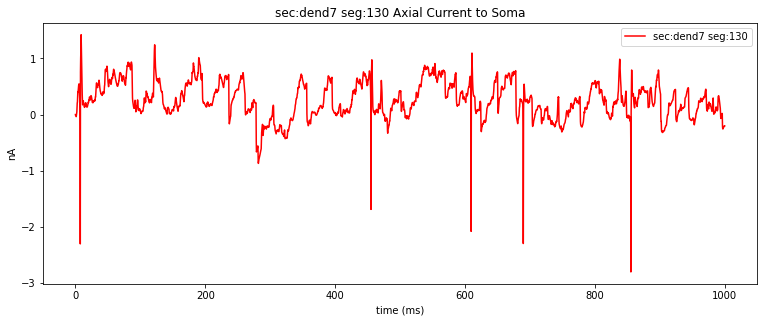

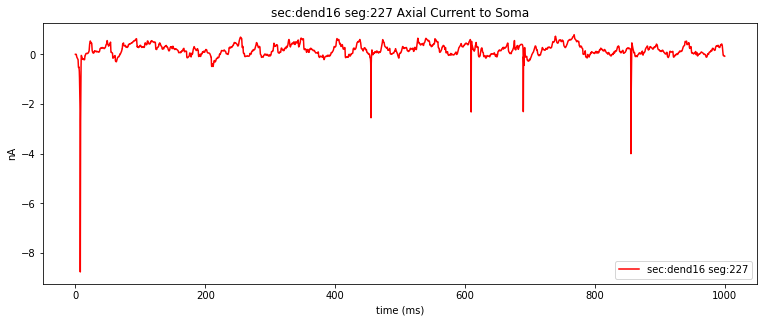

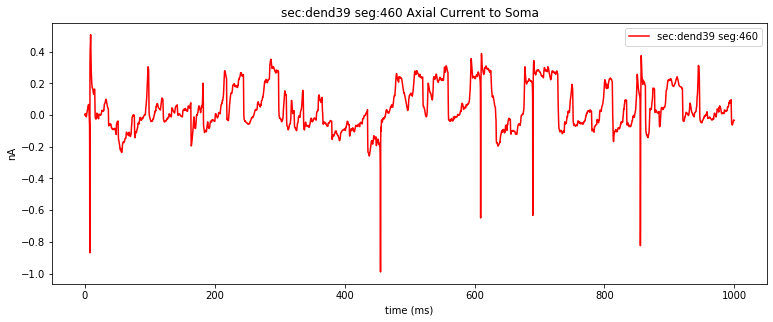

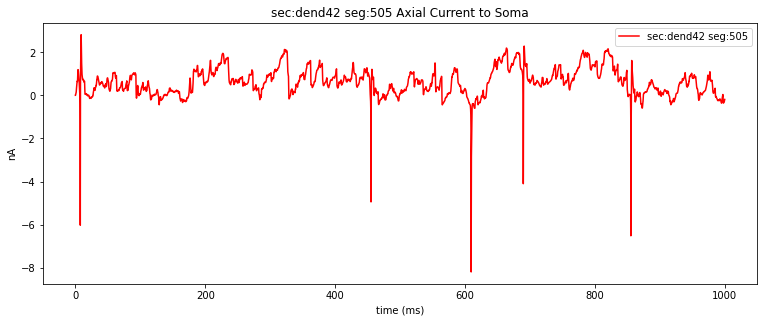

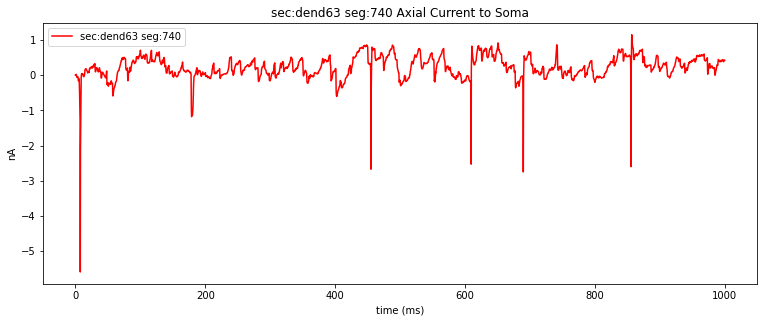

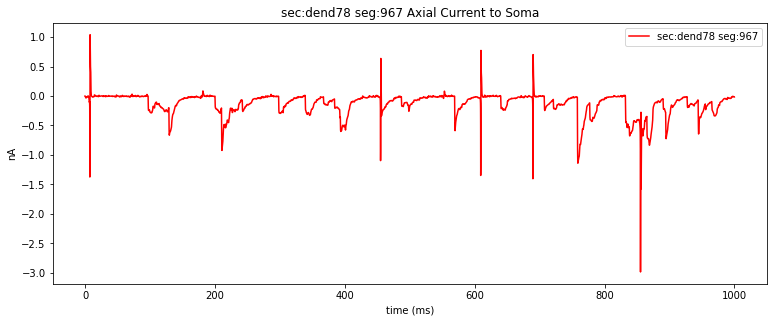

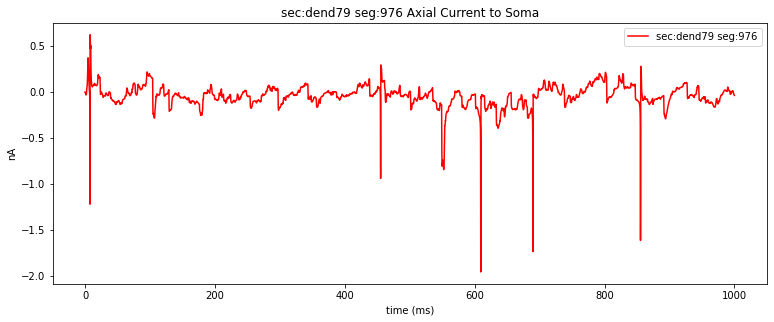

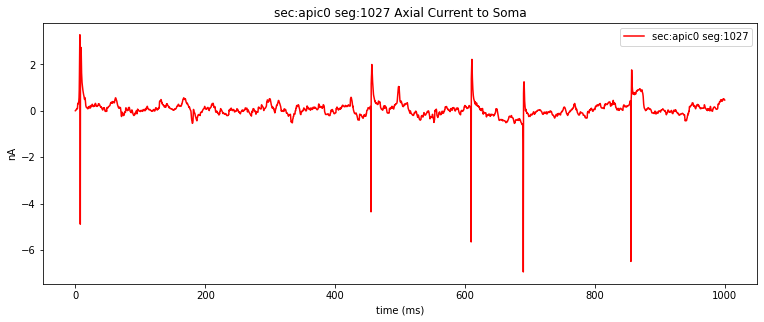

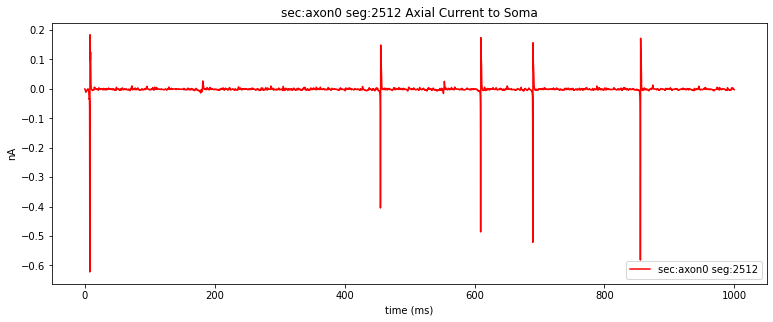

In [25]:
for probe in adjsomaprobes:
  plot_parent_axial_current(probe)